In [2]:
# Imports
import pathlib

import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim

from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset

from tqdm.auto import tqdm
from IPython.display import display

import random

In [3]:
# set_seed() and seed_worker()

def set_seed(seed=None, seed_torch=True):
	"""
    Function that controls randomness. NumPy and random modules must be imported.
  
    Args:
      seed : Integer
        A non-negative integer that defines the random state. Default is `None`.
      seed_torch : Boolean
        If `True` sets the random seed for pytorch tensors, so pytorch module
        must be imported. Default is `True`.
  
    Returns:
      Nothing.
    """
	if seed is None:
		seed = np.random.choice(2 ** 32)
	random.seed(seed)
	np.random.seed(seed)
	if seed_torch:
		torch.manual_seed(seed)
		torch.cuda.manual_seed_all(seed)
		torch.cuda.manual_seed(seed)
		torch.backends.cudnn.benchmark = False
		torch.backends.cudnn.deterministic = True

	print(f'Random seed {seed} has been set.')

	# In case that `DataLoader` is used
def seed_worker(worker_id):
	"""
    DataLoader will reseed workers following randomness in
    multi-process data loading algorithm.
  
    Args:
      worker_id: integer
        ID of subprocess to seed. 0 means that
        the data will be loaded in the main process
        Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details
  
    Returns:
      Nothing
    """
	worker_seed = torch.initial_seed() % 2**32
	np.random.seed(worker_seed)
	random.seed(worker_seed)

In [4]:
# set_device() to CPU or GPU

def set_device():
	"""
    Set the device. CUDA if available, CPU otherwise
  
    Args:
      None
  
    Returns:
      Nothing
    """
	device = "cuda" if torch.cuda.is_available() else "cpu"
	if device != "cuda":
		print("GPU is not enabled in this notebook. \n"
		      "If you want to enable it, in the menu under `Runtime` -> \n"
		      "`Hardware accelerator.` and select `GPU` from the dropdown menu")
	else:
		print("GPU is enabled in this notebook. \n"
		      "If you want to disable it, in the menu under `Runtime` -> \n"
		      "`Hardware accelerator.` and select `None` from the dropdown menu")

	return device

In [126]:
# Setting random the seed and device

SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is not enabled in this notebook. 
If you want to enable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu


Random seed 2021 has been set.


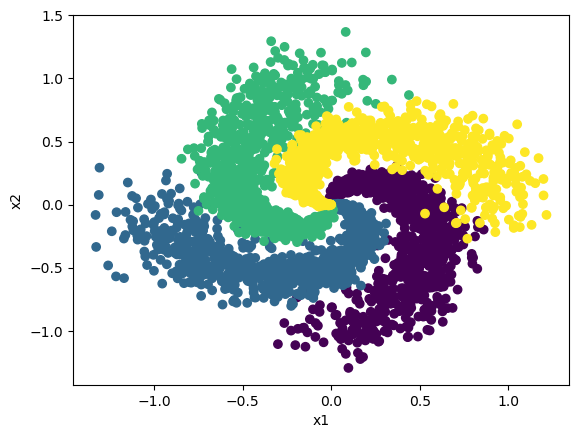

In [128]:
# Create spiral dataset

def create_spiral_dataset(K, sigma, N):
	"""
    Function to simulate spiral dataset
  
    Args:
      K: int
        Number of classes
      sigma: float
        Standard deviation
      N: int
        Number of data points
  
    Returns:
      X: torch.tensor
        Spiral data
      y: torch.tensor
        Corresponding ground truth
    """

	# Initialize t, X, y
	t = torch.linspace(0, 1, N)
	X = torch.zeros(K*N, 2)
	y = torch.zeros(K*N)

	# Create data
	for k in range(K):
		X[k*N:(k+1)*N, 0] = t*(torch.sin(2*np.pi/K*(2*t+k)) + sigma*torch.randn(N))
		X[k*N:(k+1)*N, 1] = t*(torch.cos(2*np.pi/K*(2*t+k)) + sigma*torch.randn(N))
		y[k*N:(k+1)*N] = k

	return X, y

# Set parameters
K = 4
sigma = 0.16
N = 1000

set_seed(seed=SEED)
X, y = create_spiral_dataset(K, sigma, N)
plt.scatter(X[:, 0], X[:, 1], c = y)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [127]:
# Net class

class Net(nn.Module):
	"""
    Simulate MLP Network
    """

	def __init__(self, actv, input_feature_num, hidden_unit_nums, output_feature_num, use_bias=True, learn_bias=True):
		"""
        Initialize MLP Network parameters
    
        Args:
          actv: string
            Activation function
          input_feature_num: int
            Number of input features
          hidden_unit_nums: list
            Number of units per hidden layer. List of integers
          output_feature_num: int
            Number of output features
    
        Returns:
          Nothing
        """
		super(Net, self).__init__()
		self.input_feature_num = input_feature_num # Save the input size for reshaping later
		self.hidden_unit_nums = hidden_unit_nums
		self.use_bias = use_bias
		self.learn_bias = learn_bias

		self.hidden_states = []
		self.hidden_outputs = []
		self.output_state = []
		self.processed_output = []

		self.hidden_activations = []

		layers = []
		prev_size = input_feature_num
		for hidden_size in hidden_unit_nums:
			layers.append(nn.Linear(prev_size, hidden_size, bias=use_bias))
			act_layer = actv()
			layers.append(act_layer)
			self.hidden_activations.append(act_layer)
			prev_size = hidden_size

		self.output_state_layer = nn.Linear(prev_size, output_feature_num, bias=use_bias)
		layers.append(self.output_state_layer) # Output state layer

		last_layer = actv()
		layers.append(last_layer) # ReLU after output state layer
		self.last_activation = last_layer

		self.mlp = nn.Sequential(*layers)

		# Make the weights not learn 
		if not learn_bias and use_bias:
			for layer in self.mlp:
				if isinstance(layer, nn.Linear):
					layer.bias.requires_grad = False

		self.initial_weights = []
		self.initial_biases = []
		for layer in self.mlp[::2]:
			self.initial_weights.append(layer.weight.data.clone())
			if self.use_bias:
				self.initial_biases.append(layer.bias.data.clone())

	def forward(self, x):
		"""
        Simulate forward pass of MLP Network
    
        Args:
          x: torch.tensor
            Input data
    
        Returns:
          logits: Instance of MLP
            Forward pass of MLP
        """
		
		self.hidden_states = []  # Clear previous hidden outputs
		self.hidden_outputs = []

		for layer in self.mlp:
			x = layer(x)
			if isinstance(layer, nn.Linear) and layer != self.output_state_layer and layer != self.last_activation: 
				self.hidden_states.append(x.detach())  # Store state of hidden layers before activation 
			elif layer in self.hidden_activations:
				self.hidden_outputs.append(x.detach()) # Store state of hidden layers after activation
		
		self.output_state = x.detach()  # State of the last layer before activation
		x = self.last_activation(x)
		self.processed_output = x.detach()  # Output of the last layer after activation

		return x
	
	def reinit(self):
		self.hidden_states = [] 
		self.hidden_outputs = []
	
	def test(self, data_loader, device='cpu'):
		"""
        Function to gauge network performance
    
        Args:
          data_loader: torch.utils.data type
            Combines the test dataset and sampler, and provides an iterable over the given dataset.
		  device: string
            CUDA/GPU if available, CPU otherwise
    
        Returns:
          acc: float
            Performance of the network
          total: int
            Number of datapoints in the dataloader
        """
		correct = 0
		total = 0
		for data in data_loader:
			inputs, labels = data
			inputs = inputs.to(device).float()
			labels = labels.to(device).long()

			outputs = self.forward(inputs)
			_, predicted = torch.max(outputs, 1)
			total += labels.size(0)
			correct += (predicted == labels).sum().item()

		acc = 100 * correct / total
		return total, acc
	
	def train_model(self, criterion, optimizer, train_loader, num_epochs=1, verbose=False, device='cpu'):
		"""
		Accumulate training loss/Evaluate performance
	
		Args:
		  criterion: torch.nn type
		    Loss function
		  optimizer: torch.optim type
		    Implements Adam or MSELoss algorithm.
		  train_loader: torch.utils.data type
		    Combines the train dataset and sampler, and provides an iterable over the given dataset.
		  test_loader: torch.utils.data type
		    Combines the test dataset and sampler, and provides an iterable over the given dataset.
		  num_epochs: int
		    Number of epochs [default: 1]
		  verbose: boolean
		    If True, print statistics
		  training_plot=False
		    If True, display training plot
		  device: string
		    CUDA/GPU if available, CPU otherwise
	
		Returns:
		  Nothing
		"""
		self.to(device)
		self.train()
		self.training_losses = []
		self.reinit()

		self.train_hidden_states = [[] for i in range(len(self.hidden_unit_nums))]
		self.train_hidden_outputs = [[] for i in range(len(self.hidden_unit_nums))]
		self.train_output_state = []
		self.train_processed_output = []

		self.train_labels = []

		for epoch in tqdm(range(num_epochs)):  # Loop over the dataset multiple times
			running_loss = 0.0
			epoch_hidden_states = []
			epoch_hidden_outputs = []
			for i, data in enumerate(train_loader, 0):
				# Get the inputs; data is a list of [inputs, labels]
				inputs, labels = data
				inputs = inputs.to(device).float()
				labels = labels.to(device).long()

				# Zero the parameter gradients
				optimizer.zero_grad()

				# forward + backward + optimize
				outputs = self.forward(inputs)
				for layer_idx in range(len(self.hidden_unit_nums)):
					self.train_hidden_states[layer_idx].append(self.hidden_states[layer_idx])
					self.train_hidden_outputs[layer_idx].append(self.hidden_outputs[layer_idx])
				self.train_output_state.append(self.output_state)
				self.train_processed_output.append(self.processed_output)

				# Decide criterion function
				criterion_function = eval(f"nn.{criterion}()")
				if criterion == "MSELoss":
					targets = torch.zeros((inputs.shape[0],4))
					for row in range(len(labels)):
						col = labels.int()[row]
						targets[row][col] = 1
					loss = criterion_function(outputs, targets)
				elif criterion == "CrossEntropyLoss":
					loss = criterion_function(outputs, labels)
					
				self.train_labels.append(labels)

				loss.backward()
				optimizer.step()

				self.training_losses.append(loss.item())

		# Concatenate hidden states and outputs within the current batch
		
		for layer_idx in range(len(self.hidden_unit_nums)):
			self.train_hidden_states[layer_idx] = torch.stack(self.train_hidden_states[layer_idx]).squeeze()
			self.train_hidden_outputs[layer_idx] = torch.stack(self.train_hidden_outputs[layer_idx]).squeeze()
		self.train_output_state = torch.stack(self.train_output_state).squeeze()
		self.train_processed_output = torch.stack(self.train_processed_output).squeeze()
		self.train_labels = torch.stack(self.train_labels)
		
		self.eval()

		train_total, train_acc = self.test(train_loader, device)

		self.final_weights = []
		self.final_biases = []
		for layer in self.mlp[::2]:
			self.final_weights.append(layer.weight.data)
			if self.use_bias:
				self.final_biases.append(layer.bias.data)

		if verbose:
			print(f'\nAccuracy on the {train_total} training samples: {train_acc:0.2f}')

		return train_acc
	
	def test_model(self, test_loader, verbose=True, device='cpu'):
		'''
		Evaluate performance

		Args:
		  test_loader: torch.utils.data type
		    Combines the test dataset and sampler, and provides an iterable over the given dataset.
		  verbose: boolean
		    If True, print statistics
		  device: string
		    CUDA/GPU if available, CPU otherwise

		Returns:
		  Nothing
		'''
		self.to(device)
		test_total, test_acc = self.test(test_loader, device)

		if verbose: 
			print(f'Accuracy on the {test_total} testing samples: {test_acc:0.2f}\n')
		
		return test_acc
	
	def display_summary(self, test_loader, test_acc):
		'''
		Display network summary

		Args:
		  test_loader: torch.utils.data type
		    Combines the test dataset and sampler, and provides an iterable over the given dataset.
		  device: string
		    CUDA/GPU if available, CPU otherwise

		Returns:
		  Nothing
		'''
		
		print(self.mlp)

		inputs, labels = next(iter(test_loader))

		class_averaged_hidden_layers = []
		sorted_indices_layers = []
		for hidden_layer_index in range(len(self.hidden_outputs)):
			class_averaged_hidden = torch.empty((self.processed_output.shape[1], self.hidden_outputs[hidden_layer_index].shape[1]))
			for label in torch.arange(self.processed_output.shape[1]):
				indexes = torch.where(labels == label)
				class_averaged_hidden[label,:] = torch.mean(self.hidden_outputs[hidden_layer_index][indexes], dim=0)

			max_indices = class_averaged_hidden.argmax(dim=0)
			sorted_indices = max_indices.argsort()

			class_averaged_hidden_layers.append(class_averaged_hidden)
			sorted_indices_layers.append(sorted_indices)

		class_averaged_output = torch.empty((self.processed_output.shape[1], self.processed_output.shape[1]))
		for labelO in torch.arange(self.processed_output.shape[1]):
			indexesO = torch.where(labels == labelO)
			class_averaged_output[labelO,:] = torch.mean(self.processed_output[indexesO], dim=0)
			
		fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

		for i, (class_averaged_hidden, sorted_indices) in enumerate(zip(class_averaged_hidden_layers, sorted_indices_layers)):
			imH = axes[0][i].imshow(class_averaged_hidden[:,sorted_indices].T, aspect='auto', interpolation='none')
			axes[0][i].set_title(f'Class Averaged Hidden Layer {i+1}')
			axes[0][i].set_xlabel('Label')
			axes[0][i].set_ylabel('Neuron')
			fig.colorbar(imH, ax=axes[0][i])

			axes[0][i].set_xticks(range(class_averaged_hidden.shape[0]))
			axes[0][i].set_xticklabels(range(class_averaged_hidden.shape[0]))

		imO = axes[1][0].imshow(class_averaged_output.T, aspect='auto')
		axes[1][0].set_title(f'Class Averaged Output')
		axes[1][0].set_xlabel('Label')
		axes[1][0].set_ylabel('Neuron')
		fig.colorbar(imO, ax=axes[1][0])

		axes[1][0].set_xticks(range(class_averaged_output.shape[0]))
		axes[1][0].set_xticklabels(range(class_averaged_output.shape[0]))
		axes[1][0].set_yticks(range(class_averaged_output.shape[1]))
		axes[1][0].set_yticklabels(range(class_averaged_output.shape[1]))

		axes[1][1].plot(self.training_losses, label=f"Test Accuracy: {test_acc}")
		axes[1][1].set_xlabel('Batch')
		axes[1][1].set_ylabel('Training Loss')
		axes[1][1].legend(loc='best', frameon=False)

		plt.tight_layout()
		plt.show()

	def plot_params(self):
		'''
		Plot initial and final weights and biases for all layers.

		Args:
		  Nothing

		Returns:
		  Nothing
		'''

		num_layers = len(self.initial_weights)
		fig, axes = plt.subplots(nrows=num_layers, ncols=2, figsize=(12, 3*num_layers))

		for i, (initialW, finalW) in enumerate(zip(self.initial_weights, self.final_weights)):
			iw = initialW.flatten()
			fw = finalW.flatten()

			axes[i][0].hist([iw, fw], bins=30, label=['Initial Weights', 'Final Weights'])

			if (i == len(self.initial_weights)-1):
				axes[i][0].set_title('Output Layer Weights')
			else:
				axes[i][0].set_title(f'Hidden Layer {i+1} Weights')

			axes[i][0].set_xlabel("Weight Value")
			axes[i][0].set_ylabel("Frequency")
			axes[i][0].legend()

		if self.use_bias:
			for i, (initialB, finalB) in enumerate(zip(self.initial_biases, self.final_biases)):
				ib = initialB.flatten()
				fb = finalB.flatten()

				axes[i][1].hist([ib, fb], bins=30, label=['Initial Biases', 'Final Biases'])

				if (i == len(self.initial_biases)-1):
					axes[i][1].set_title('Output Layer Biases')
				else:
					axes[i][1].set_title(f'Hidden Layer {i+1} Biases')

				axes[i][1].set_xlabel("Bias Value")
				axes[i][1].set_ylabel("Frequency")
				axes[i][1].legend()
		else:
			axes[0][1].set_title('Biases are not used in this network')

		plt.tight_layout()
		plt.show()

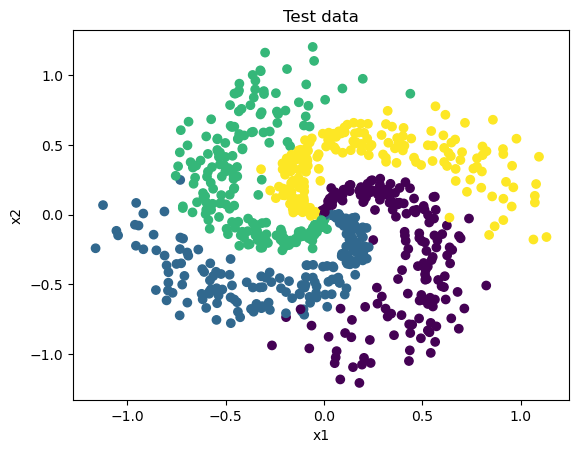

In [129]:
# Shuffle and split data; define X_test, y_test, X_train, y_train

def shuffle_and_split_data(X, y, seed):
	"""
    Helper function to shuffle and split data
  
    Args:
      X: torch.tensor
        Input data
      y: torch.tensor
        Corresponding target variables
      seed: int
        Set seed for reproducibility
  
    Returns:
      X_test: torch.tensor
        Test data [20% of X]
      y_test: torch.tensor
        Labels corresponding to above mentioned test data
      X_train: torch.tensor
        Train data [80% of X]
      y_train: torch.tensor
        Labels corresponding to above mentioned train data
    """
	# Set seed for reproducibility
	torch.manual_seed(seed)
	# Number of samples
	N = X.shape[0]
	# Shuffle data
	shuffled_indices = torch.randperm(N)   # Get indices to shuffle data, could use torch.randperm
	X = X[shuffled_indices]
	y = y[shuffled_indices]

	# Split data into train/test
	test_size = int(0.2 * N)    # Assign test datset size using 20% of samples
	X_test = X[:test_size]
	y_test = y[:test_size]
	X_train = X[test_size:]
	y_train = y[test_size:]

	return X_test, y_test, X_train, y_train

X_test, y_test, X_train, y_train = shuffle_and_split_data(X, y, seed=SEED)
plt.figure()
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Test data')
plt.show()

In [130]:
# Train and test DataLoaders

g_seed = torch.Generator()
g_seed.manual_seed(SEED)

batch_size = 1
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=len(test_data),
                         shuffle=False, num_workers=0,
                         worker_init_fn=seed_worker,
                         generator=g_seed)

train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, drop_last=True,
                          shuffle=True, num_workers=0,
                          worker_init_fn=seed_worker,
                          generator=g_seed)

In [ ]:
# Finding optimal learning rate

set_seed(SEED)
g_seed.manual_seed(SEED)
net1 = Net(nn.ReLU, X_train.shape[1], [128, 32], K).to(DEVICE)
criterion = "MSELoss"
num_epochs = 2

loss_history = []
learning_rates = np.arange(0.15, 0.25 + 0.01, 0.01)
for i in learning_rates:
	optimizer = optim.SGD(net1.parameters(), lr=i)
	loss = net1.train_model(criterion, optimizer, train_loader, num_epochs=num_epochs, verbose=True, device=DEVICE)
	loss_history.append(loss)

plt.figure()
plt.plot(learning_rates, loss_history)

# find and store values for learned bias, no bias, and no learning bias

In [142]:
# Train and Test model

set_seed(SEED)
g_seed.manual_seed(SEED)
net = Net(nn.ReLU, X_train.shape[1], [128, 32], K, use_bias=True, learn_bias=True).to(DEVICE)
criterion = "MSELoss"
optimizer = optim.SGD(net.parameters(), lr=0.09)
num_epochs = 2

net.train_model(criterion, optimizer, train_loader, num_epochs=num_epochs, device=DEVICE)

test_acc = net.test_model(test_loader, verbose=False, device=DEVICE)

Random seed 2021 has been set.


  0%|          | 0/2 [00:00<?, ?it/s]

Sequential(
  (0): Linear(in_features=2, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=4, bias=True)
  (5): ReLU()
)


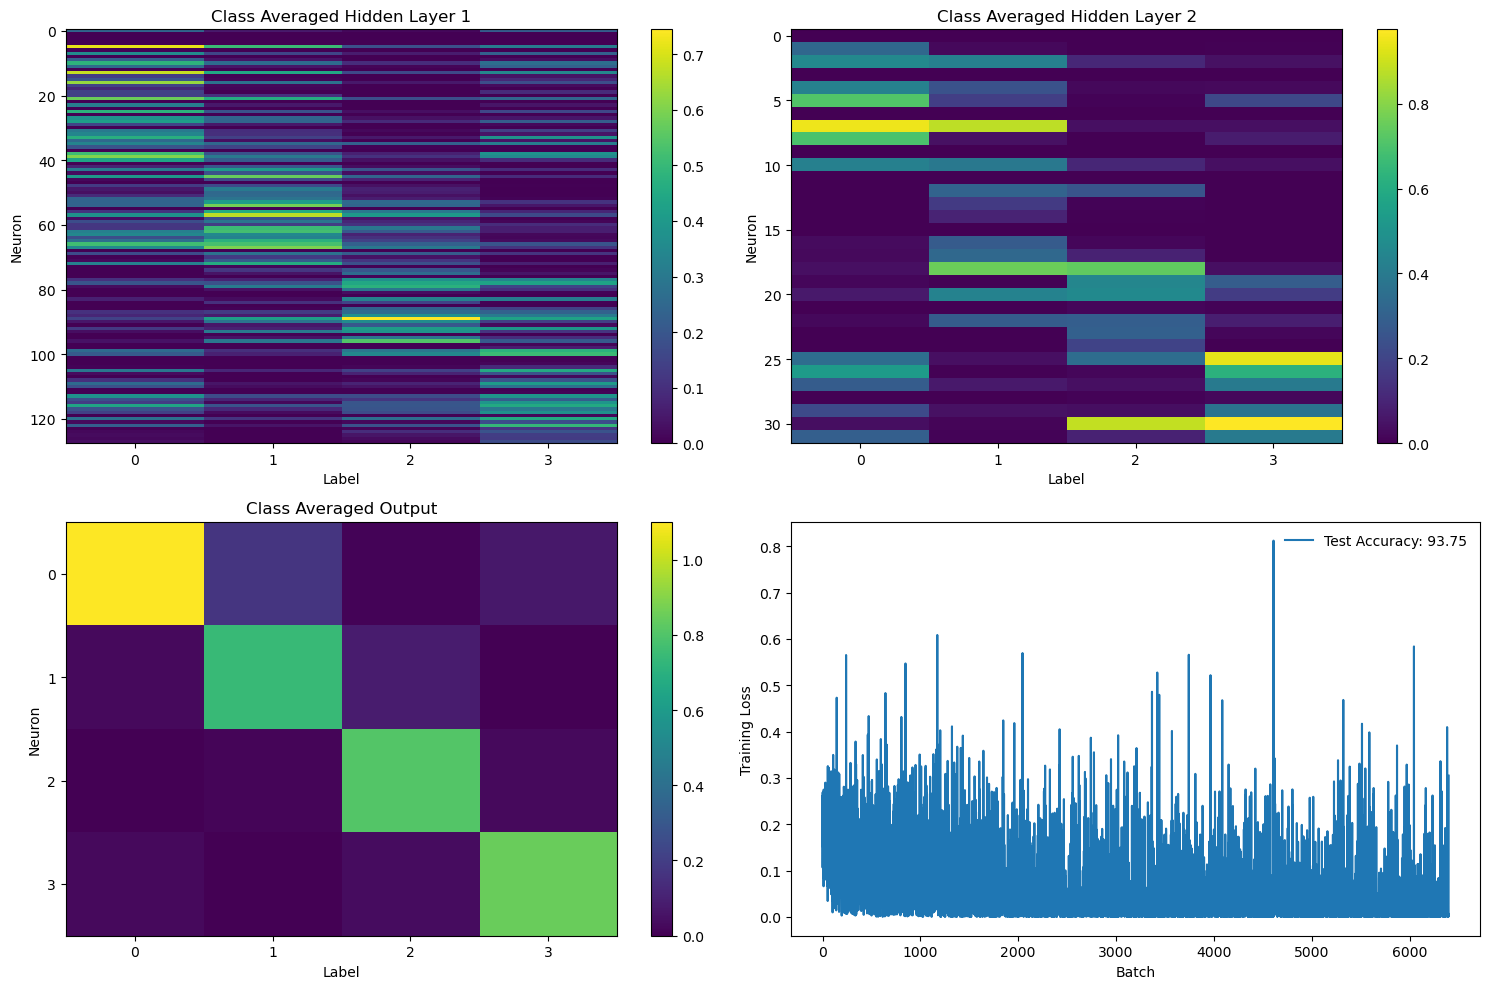

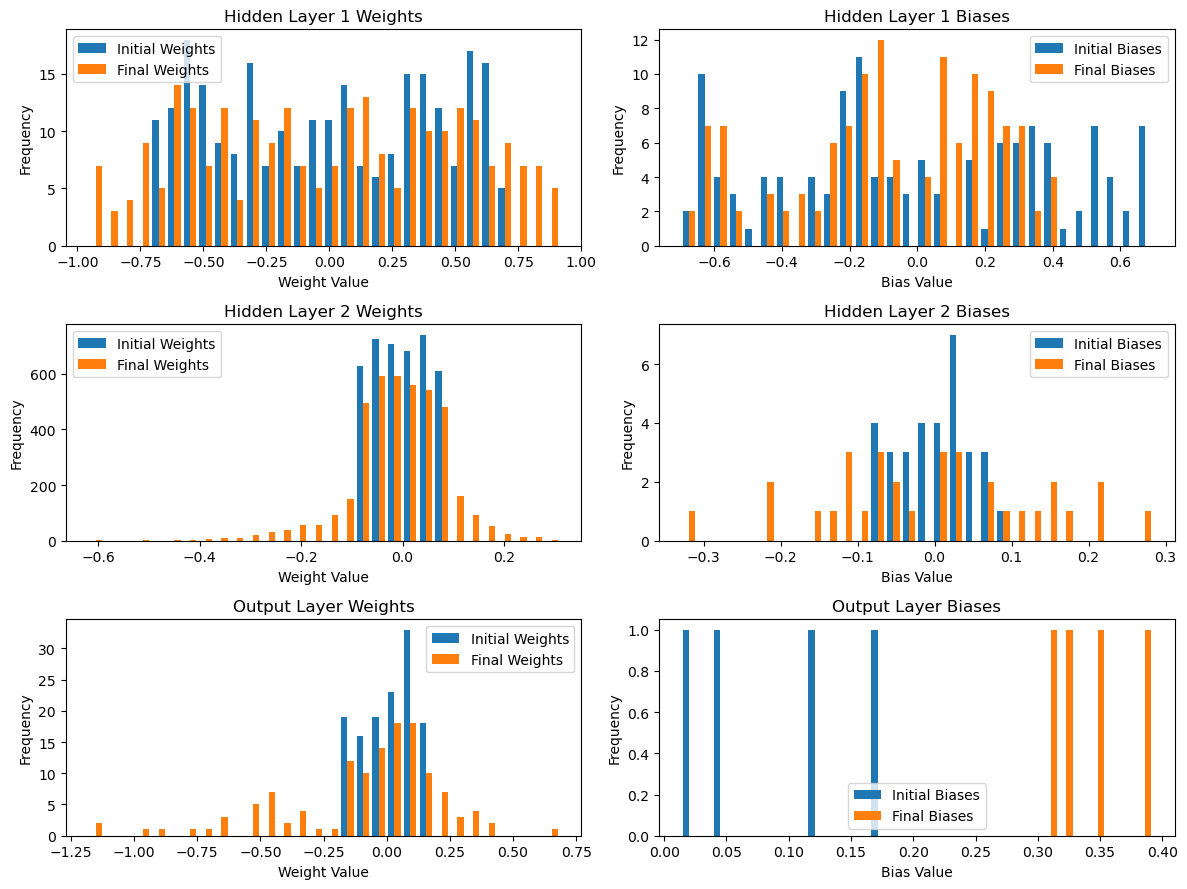

In [136]:
# Display Information

net.display_summary(test_loader, test_acc)
net.plot_params()

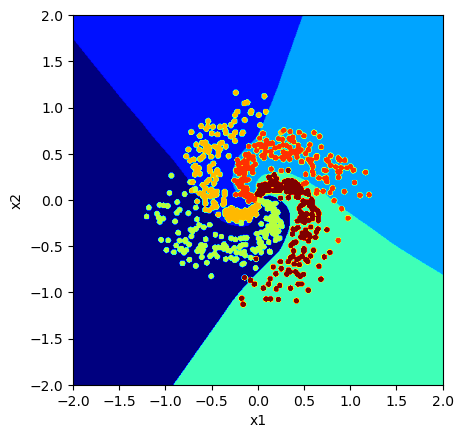

In [132]:
# Graph of sorted spiral data

def sample_grid(M=500, x_max=2.0):
	"""
    Helper function to simulate sample meshgrid
  
    Args:
      M: int
        Size of the constructed tensor with meshgrid
      x_max: float
        Defines range for the set of points
  
    Returns:
      X_all: torch.tensor
        Concatenated meshgrid tensor
    """
	ii, jj = torch.meshgrid(torch.linspace(-x_max, x_max, M),
	                        torch.linspace(-x_max, x_max, M),
	                        indexing="ij")
	X_all = torch.cat([ii.unsqueeze(-1),
	                   jj.unsqueeze(-1)],
	                  dim=-1).view(-1, 2)
	return X_all


def plot_decision_map(X_all, y_pred, X_test, y_test,
                      M=500, x_max=2.0, eps=1e-3):
	"""
    Helper function to plot decision map
  
    Args:
      X_all: torch.tensor
        Concatenated meshgrid tensor
      y_pred: torch.tensor
        Labels predicted by the network
      X_test: torch.tensor
        Test data
      y_test: torch.tensor
        Labels of the test data
      M: int
        Size of the constructed tensor with meshgrid
      x_max: float
        Defines range for the set of points
      eps: float
        Decision threshold
  
    Returns:
      Nothing
    """
	decision_map = torch.argmax(y_pred, dim=1)

	for i in range(len(X_test)):
		indices = (X_all[:, 0] - X_test[i, 0])**2 + (X_all[:, 1] - X_test[i, 1])**2 < eps
		decision_map[indices] = (K + y_test[i]).long()

	decision_map = decision_map.view(M, M)
	plt.imshow(decision_map, extent=[-x_max, x_max, -x_max, x_max], cmap='jet')
	plt.xlabel('x1')
	plt.ylabel('x2')
	plt.show()
	
X_all = sample_grid()
y_pred = net(X_all.to(DEVICE)).cpu()
plot_decision_map(X_all, y_pred, X_test, y_test)

In [144]:
set_seed(SEED)
g_seed.manual_seed(SEED)
criterion = "MSELoss"
num_epochs = 2

no_bias_net = Net(nn.ReLU, X_train.shape[1], [128, 32], K, use_bias=False, learn_bias=False).to(DEVICE)
optimizer = optim.SGD(no_bias_net.parameters(), lr=0.09)
no_bias_net.train_model(criterion, optimizer, train_loader, num_epochs=num_epochs, device=DEVICE)
no_bias_test_acc = no_bias_net.test_model(test_loader, verbose=False, device=DEVICE)

no_learn_bias_net = Net(nn.ReLU, X_train.shape[1], [128, 32], K, use_bias=True, learn_bias=False).to(DEVICE)
optimizer = optim.SGD(no_learn_bias_net.parameters(), lr=0.09)
no_learn_bias_net.train_model(criterion, optimizer, train_loader, num_epochs=num_epochs, device=DEVICE)
no_learn_bias_test_acc = no_learn_bias_net.test_model(test_loader, verbose=False, device=DEVICE)

Random seed 2021 has been set.


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

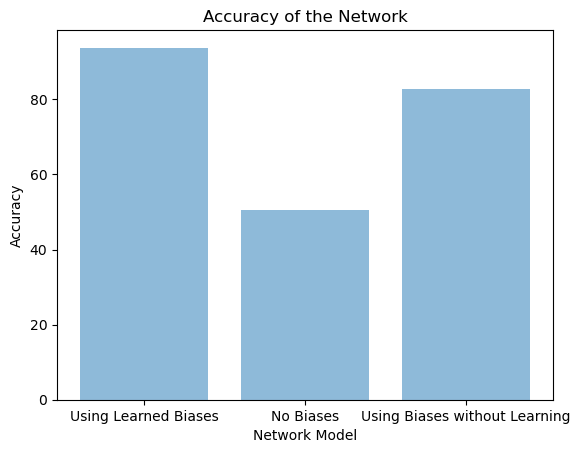

In [145]:
chartLabels = ['Using Learned Biases', 'No Biases', 'Using Biases without Learning']
chartData = [test_acc, no_bias_test_acc, no_learn_bias_test_acc]
plt.bar(chartLabels, chartData, alpha=0.5)
plt.xlabel('Network Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of the Network')
plt.show()